### Data analysis

In [13]:
import pandas as pd

casting_df = pd.read_csv('data/dataset2.csv')
casting_df.columns = casting_df.iloc[0]
casting_df = casting_df[1:].reset_index(drop=True)
casting_df = casting_df.iloc[2:]

casting_df.head()

,number,date,height_1,height_2,height_3,width_1,width_2,width_3,temp,bed_temp,humidity,layer_count,slicer_layer_height,slicer_layer_width,slicer_nozzle_speed,slicer_extrusion_multiplier
2,3,31.10.2024,"0,65","0,75","0,82","1,75","1,96","1,75","18,5",NaN,41%,1,"0,8","1,5",10,1
3,4,31.10.2024,"0,78","0,87","0,84","2,21","1,77","2,14","18,5",NaN,41%,1,"0,8","1,5",10,1
4,5,31.10.2024,"0,86","0,78","0,89","1,96","1,85","1,93","18,5",NaN,41%,1,"0,8","1,5",10,1
5,6,31.10.2024,"0,85","0,86","0,98","2,17","1,93","1,9","18,5",NaN,41%,1,"0,8","1,5",10,1
6,7,31.10.2024,"0,81","0,94","0,91","2,25","2,05","2,07","18,5",NaN,41%,1,"0,8","1,5",10,1


In [14]:
casting_df.drop(columns=['date', 'number'], inplace=True)

casting_df.dropna(inplace=True)

# Replace commas with dots and convert to float
casting_df = casting_df.map(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else float(x))

casting_df.head()

,height_1,height_2,height_3,width_1,width_2,width_3,temp,bed_temp,humidity,layer_count,slicer_layer_height,slicer_layer_width,slicer_nozzle_speed,slicer_extrusion_multiplier


In [15]:
len(casting_df)

0

In [4]:
# casting_df.to_csv('data/cleaned_df.csv', index=False)

In [5]:
# Calculate average values for height and width
casting_df['height_average'] = (casting_df['height_1'] + casting_df['height_2'] + casting_df['height_3'])/3
casting_df['width_average'] = (casting_df['width_1'] + casting_df['width_2'] + casting_df['width_3'])/3

# Calculate average difference values for height and width
casting_df['avg_height_diff'] = casting_df['height_average']-casting_df['slicer_layer_height']
casting_df['avg_width_diff'] = casting_df['width_average']-casting_df['slicer_layer_width']
casting_df['avg_diff'] = (casting_df['avg_height_diff']+casting_df['avg_width_diff'])/2

Overall data distribution

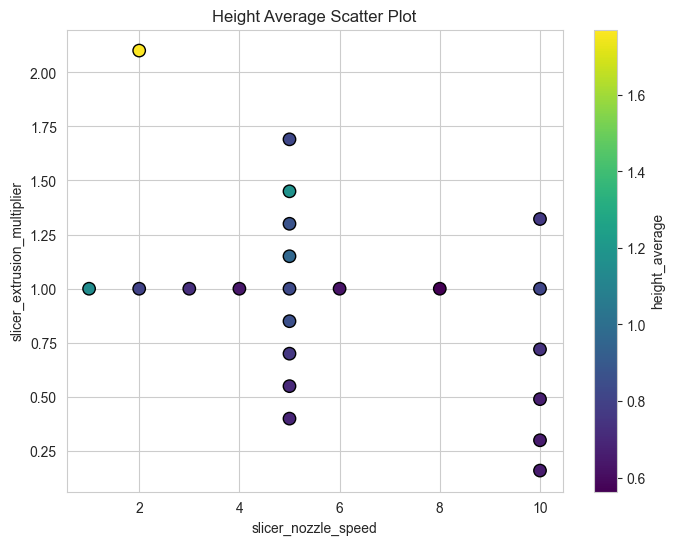

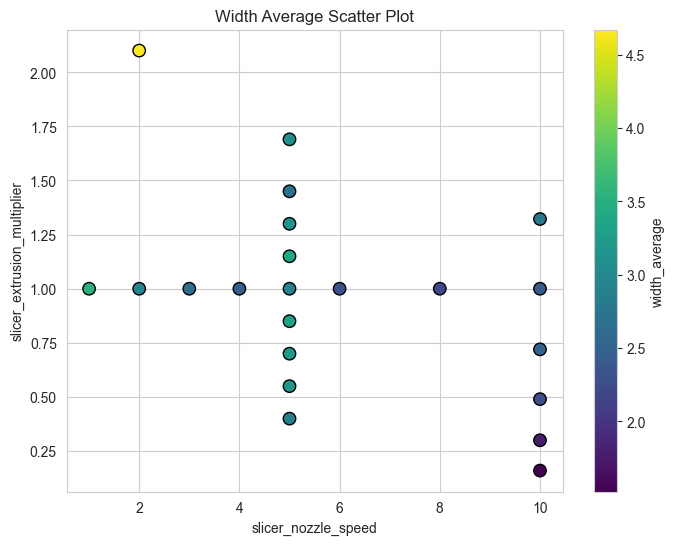

In [6]:
import matplotlib.pyplot as plt

# Group by input features and compute the mean output
casting_df_grouped = casting_df.groupby(['slicer_nozzle_speed', 'slicer_extrusion_multiplier'], as_index=False).mean()

# Function to create scatter plot
def plot_scatter(df, x, y, z, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df[x], df[y], c=df[z], cmap='viridis', edgecolor='k', s=80)
    plt.colorbar(scatter, label=z)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.gca()
    plt.show()

# Scatter plots for both outputs using the averaged values
plot_scatter(casting_df_grouped, 'slicer_nozzle_speed', 'slicer_extrusion_multiplier', 'height_average', 'Height Average Scatter Plot')
plot_scatter(casting_df_grouped, 'slicer_nozzle_speed', 'slicer_extrusion_multiplier', 'width_average', 'Width Average Scatter Plot')



Don't think that the next cell is very informative but let it be here

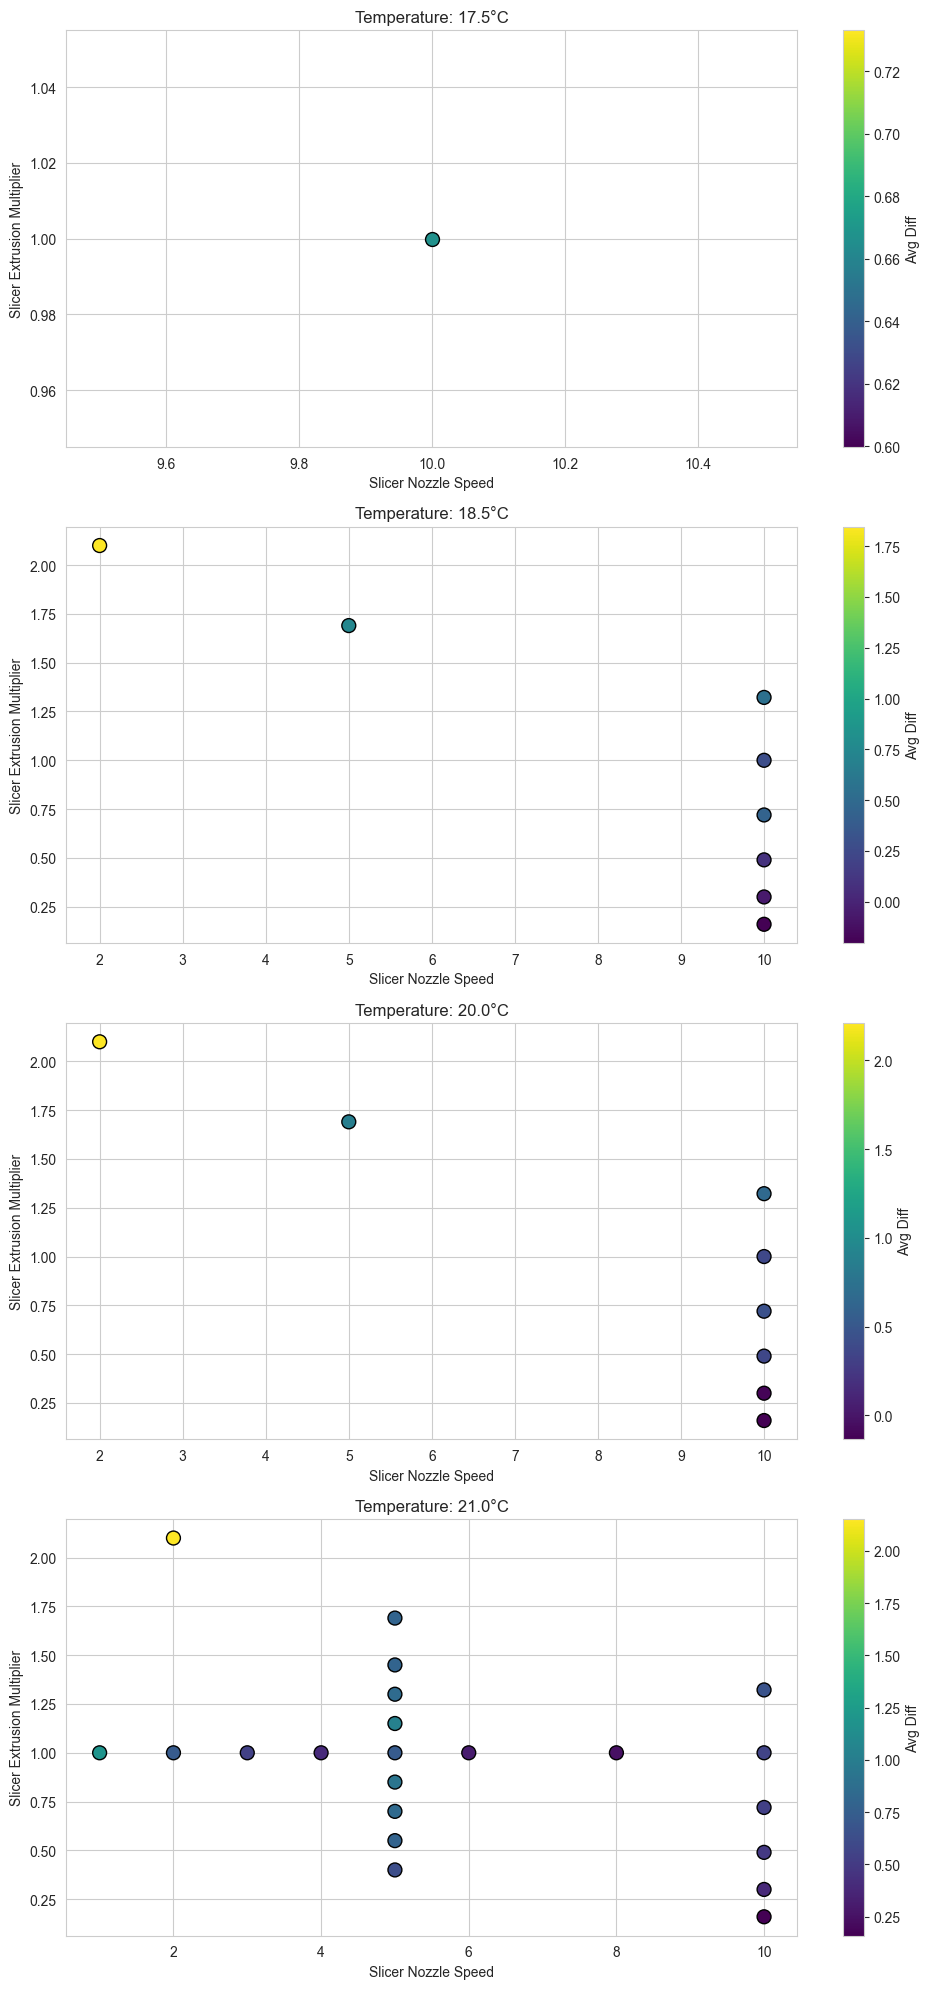

In [7]:
import matplotlib.pyplot as plt

# Group by 'temp', 'slicer_nozzle_speed', and 'slicer_extrusion_multiplier', taking the mean of 'avg_diff'
avg_diff_df = casting_df.groupby(['temp', 'slicer_nozzle_speed', 'slicer_extrusion_multiplier'], as_index=False).mean()

# Get unique temperatures
unique_temps = avg_diff_df['temp'].unique()

# Create a plot for each unique temp value
plt.figure(figsize=(10, 5 * len(unique_temps)))
for i, temp in enumerate(unique_temps, start=1):
    plt.subplot(len(unique_temps), 1, i)
    
    # Filter DataFrame for the current temp
    temp_df = avg_diff_df[avg_diff_df['temp'] == temp]
    
    # Create scatter plot with color based on 'avg_diff'
    scatter = plt.scatter(
        x=temp_df['slicer_nozzle_speed'],
        y=temp_df['slicer_extrusion_multiplier'],
        c=temp_df['avg_diff'],
        cmap='viridis',
        edgecolor='k',
        s=100
    )
    
    # Set plot title and labels
    plt.title(f'Temperature: {temp}°C')
    plt.xlabel('Slicer Nozzle Speed')
    plt.ylabel('Slicer Extrusion Multiplier')
    
    # Add color bar for 'avg_diff' values
    cbar = plt.colorbar(scatter)
    cbar.set_label('Avg Diff')

# Adjust layout
plt.tight_layout()
plt.show()

Here I think that median is more informative than mean. Not very good results for width actually

In [8]:
print(f"Min, median and max average height values: {casting_df['height_average'].min()}, {casting_df['height_average'].median()}, {casting_df['height_average'].max()}")
print(f"Min, median and max average width values: {casting_df['width_average'].min()}, {casting_df['width_average'].median()}, {casting_df['width_average'].max()}")
print(f"\nTarget height = {casting_df['slicer_layer_height'].iloc[0]}, target width = {casting_df['slicer_layer_width'].iloc[0]}")

Min, median and max average height values: 0.5499999999999999, 0.7733333333333334, 2.0666666666666664
Min, median and max average width values: 1.2666666666666666, 2.5233333333333334, 4.973333333333334

Target height = 0.8, target width = 1.5


### Basic models

Height outliers: 4 rows
0   height_1  height_2  height_3  width_1  width_2  width_3  temp  humidity  \
7       1.23      1.65      1.60     4.52     4.51     4.47  18.5      0.41   
23      1.44      2.01      1.80     5.00     5.02     4.90  20.0      0.41   
39      2.03      2.02      2.15     4.38     4.32     4.91  21.0      0.40   
63      1.30      1.25      0.99     2.87     2.79     2.47  21.0      0.34   

0   slicer_layer_height  slicer_layer_width  slicer_nozzle_speed  \
7                   0.8                 1.5                  2.0   
23                  0.8                 1.5                  2.0   
39                  0.8                 1.5                  2.0   
63                  0.8                 1.5                  5.0   

0   slicer_extrusion_multiplier  height_average  width_average  \
7                          2.10        1.493333       4.500000   
23                         2.10        1.750000       4.973333   
39                         2.10        2.

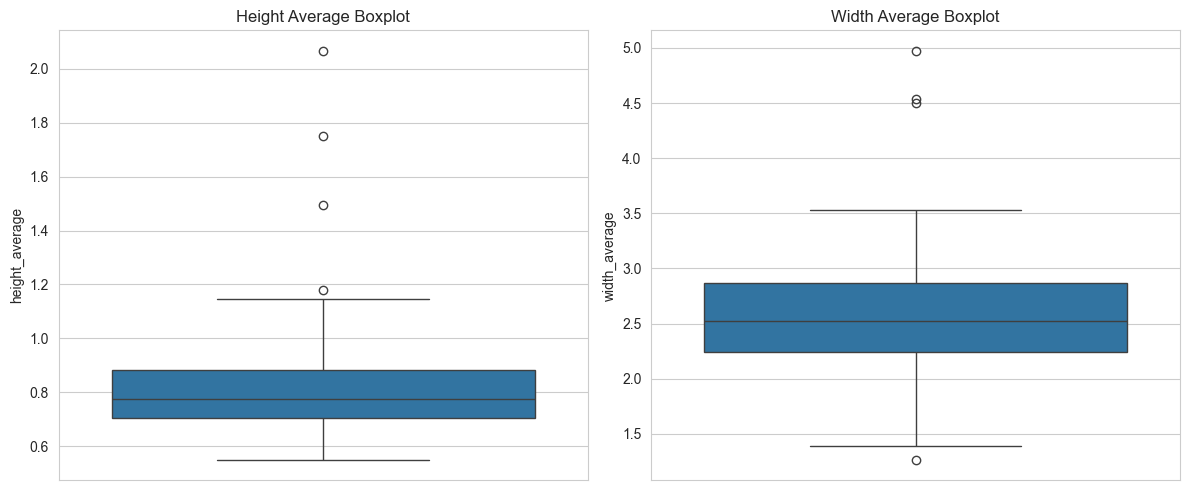

Original dataframe shape: (66, 17)
Cleaned dataframe shape: (61, 17)
Number of rows removed: 5


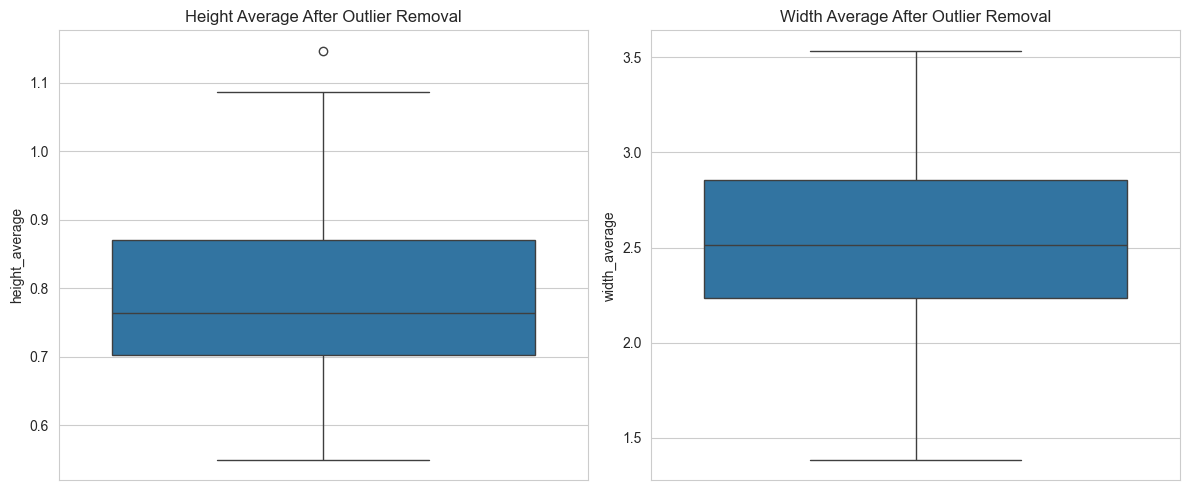

In [23]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Identify outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Check for outliers in height measurements
height_outliers = detect_outliers(casting_df, 'height_average')
print(f"Height outliers: {len(height_outliers)} rows")
print(height_outliers)

# Check for outliers in width measurements
width_outliers = detect_outliers(casting_df, 'width_average')
print(f"Width outliers: {len(width_outliers)} rows")
print(width_outliers)

# Visualize outliers using boxplots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=casting_df['height_average'])
plt.title('Height Average Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(y=casting_df['width_average'])
plt.title('Width Average Boxplot')
plt.tight_layout()
plt.show()

# Option 1: Remove outliers (implemented)
def remove_outliers(df, columns):
    df_no_outliers = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) &
                                        (df_no_outliers[column] <= upper_bound)]
    return df_no_outliers

# Remove outliers from both height and width columns
casting_df_cleaned = remove_outliers(casting_df, ['height_average', 'width_average'])

# Print the shape of the original and cleaned dataframes to see how many rows were removed
print(f"Original dataframe shape: {casting_df.shape}")
print(f"Cleaned dataframe shape: {casting_df_cleaned.shape}")
print(f"Number of rows removed: {casting_df.shape[0] - casting_df_cleaned.shape[0]}")

# Optional: Visualize data distribution after outlier removal
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=casting_df_cleaned['height_average'])
plt.title('Height Average After Outlier Removal')

plt.subplot(1, 2, 2)
sns.boxplot(y=casting_df_cleaned['width_average'])
plt.title('Width Average After Outlier Removal')
plt.tight_layout()
plt.show()

Preparation steps

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define the input and output variables
X = casting_df_cleaned[['slicer_nozzle_speed', 'slicer_extrusion_multiplier', 'temp']]
y = casting_df_cleaned[['height_average', 'width_average']]
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

Model defining

In [28]:
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor

# GBR
gbr = GradientBoostingRegressor()
gbr_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
gbr_model = {"name": "GBR", "model": gbr, "param_grid": gbr_param_grid}

# GPR
gpr = GaussianProcessRegressor()
gpr_param_grid = {
    'kernel': [j * RBF(length_scale=[i], length_scale_bounds='fixed') for i in [0.1, 0.5, 1, 2, 5, 10] for j in range(1, 5)],
    'alpha': [0.0001, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
}
gpr_model = {"name": "GPR", "model": gpr, "param_grid": gpr_param_grid}

# SVM
svr = SVR()
svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}
svr_model = {"name": "SVM", "model": svr, "param_grid": svr_param_grid}

# XGBoost
xgb = XGBRegressor(objective='reg:squarederror')
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = {"name": "XGB", "model": xgb, "param_grid": xgb_param_grid}

# Save models
models = (gbr_model, gpr_model, svr_model, xgb_model)


Model training, evaluation

In [38]:
from sklearn.metrics import mean_absolute_error

models_predictions = []
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models:

        # Use GridSearchCV to optimize hyperparameters for each target independently, default metric is R2
        model_height = GridSearchCV(model["model"], model["param_grid"], cv=cv, scoring='neg_mean_absolute_error')
        model_width = GridSearchCV(model["model"], model["param_grid"], cv=cv, scoring='neg_mean_absolute_error')

        # Fit the models separately on the training data
        model_height.fit(X_train, y_train['height_average'])
        model_width.fit(X_train, y_train['width_average'])

        # Extract best estimators from GridSearchCV
        best_model_height = model_height.best_estimator_
        best_model_width = model_width.best_estimator_

        # Final predictions on the data
        val_height_preds = best_model_height.predict(X_val)
        val_width_preds = best_model_width.predict(X_val)
        train_height_preds = best_model_height.predict(X_train)
        train_width_preds = best_model_width.predict(X_train)

        # Store predictions
        models_predictions.append({"name": model["name"],
                                "height_predicted": val_height_preds,
                                "width_predicted": val_width_preds})

        # Used MAE for easier interpretation
        train_height_MAE_loss = mean_absolute_error(y_train['height_average'], train_height_preds)
        train_width_MAE_loss = mean_absolute_error(y_train['width_average'], train_width_preds)

        val_height_MAE_loss = mean_absolute_error(y_val['height_average'], val_height_preds)
        val_width_MAE_loss = mean_absolute_error(y_val['width_average'], val_width_preds)

        print(model["name"], "model:")
        print(f"MAE height and width on the train set: {train_height_MAE_loss}, {train_width_MAE_loss}")
        print(f"MAE height and width on the validation set: {val_height_MAE_loss}, {val_width_MAE_loss}\n")

GBR model:
MAE height and width on the train set: 0.03999848870757624, 0.11395606415885744
MAE height and width on the validation set: 0.09765676370405525, 0.2623267090678654

GPR model:
MAE height and width on the train set: 0.061219782339136296, 0.19648549628402126
MAE height and width on the validation set: 0.10781944978320553, 0.30672255843237667

SVM model:
MAE height and width on the train set: 0.06990060836662168, 0.23580206368026077
MAE height and width on the validation set: 0.09962624516524887, 0.35410332313392656

XGB model:
MAE height and width on the train set: 0.04357667326927185, 0.1360259151837183
MAE height and width on the validation set: 0.09563279658033136, 0.24073677849351308



Performing Bayesian optimization for XGBoost height prediction...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalli

/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warn

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warn

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warn

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  w

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  w

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  w

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  w

Best GPR parameters for height: {'kernel': '1**2 * Matern(length_scale=1, nu=0.5)', 'alpha': 0.0011233621690895233, 'n_restarts_optimizer': 7, 'normalize_y': False}
Best GPR height MAE: 0.069502

Performing Bayesian optimization for GPR width prediction...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproce

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/nazarii/projects/ipm/robocasting/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

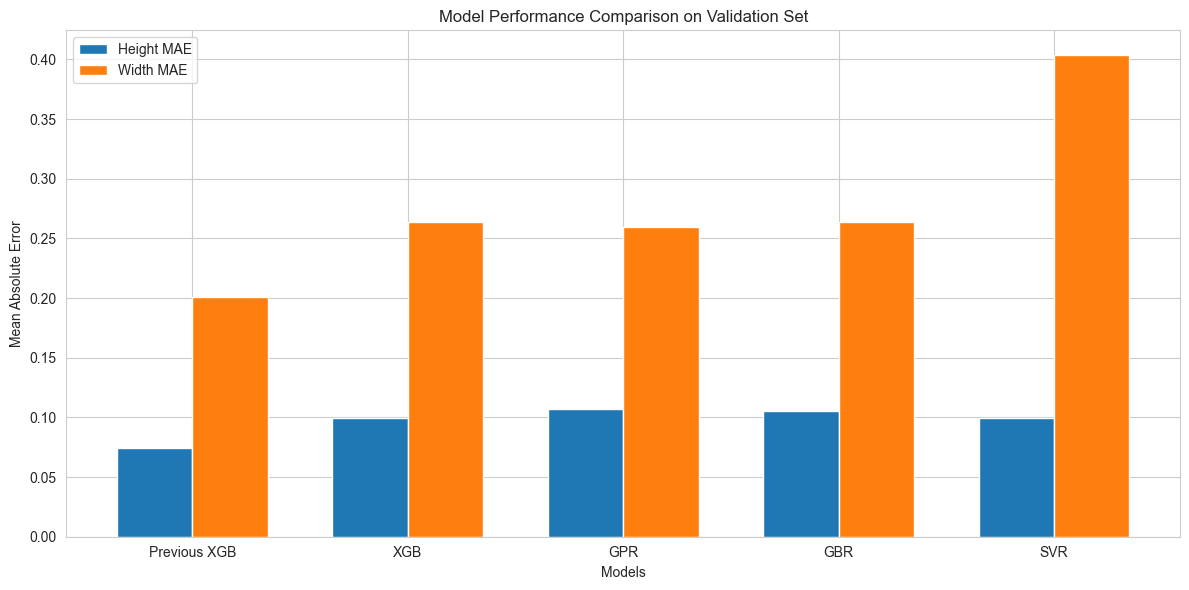

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Define scoring metric
# mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mae_scorer = 'neg_mean_absolute_error'

# Make sure X_train, X_val, y_train, y_val are already defined
# If using a DataFrame for X_scaled:
# X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

### 1. XGBoost with Bayesian Optimization ###
from xgboost import XGBRegressor

xgb_search_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(2, 10),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'gamma': Real(0, 1),
    'min_child_weight': Integer(1, 6),
    'reg_alpha': Real(0, 1),
    'reg_lambda': Real(0, 1)
}

print("Performing Bayesian optimization for XGBoost height prediction...")
xgb_bayes_height = BayesSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    xgb_search_space,
    n_iter=50,  # Number of parameter settings that are evaluated
    cv=cv,
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
xgb_bayes_height.fit(X_train, y_train['height_average'])
best_xgb_height = xgb_bayes_height.best_estimator_
print(f"Best XGBoost parameters for height: {xgb_bayes_height.best_params_}")
print(f"Best XGBoost height MAE: {-xgb_bayes_height.best_score_:.6f}")

print("\nPerforming Bayesian optimization for XGBoost width prediction...")
xgb_bayes_width = BayesSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    xgb_search_space,
    n_iter=50,
    cv=cv,
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
xgb_bayes_width.fit(X_train, y_train['width_average'])
best_xgb_width = xgb_bayes_width.best_estimator_
print(f"Best XGBoost parameters for width: {xgb_bayes_width.best_params_}")
print(f"Best XGBoost width MAE: {-xgb_bayes_width.best_score_:.6f}")

### 2. Gradient Boosting Regressor with Bayesian Optimization ###
from sklearn.ensemble import GradientBoostingRegressor

gbr_search_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'subsample': Real(0.6, 1.0),
    'max_features': Categorical(['sqrt', 'log2', None])
}

print("\nPerforming Bayesian optimization for GBR height prediction...")
gbr_bayes_height = BayesSearchCV(
    GradientBoostingRegressor(random_state=42),
    gbr_search_space,
    n_iter=50,
    cv=cv,
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
gbr_bayes_height.fit(X_train, y_train['height_average'])
best_gbr_height = gbr_bayes_height.best_estimator_
print(f"Best GBR parameters for height: {gbr_bayes_height.best_params_}")
print(f"Best GBR height MAE: {-gbr_bayes_height.best_score_:.6f}")

print("\nPerforming Bayesian optimization for GBR width prediction...")
gbr_bayes_width = BayesSearchCV(
    GradientBoostingRegressor(random_state=42),
    gbr_search_space,
    n_iter=50,
    cv=cv,
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
gbr_bayes_width.fit(X_train, y_train['width_average'])
best_gbr_width = gbr_bayes_width.best_estimator_
print(f"Best GBR parameters for width: {gbr_bayes_width.best_params_}")
print(f"Best GBR width MAE: {-gbr_bayes_width.best_score_:.6f}")

### 3. Gaussian Process Regressor with Bayesian Optimization ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel

# For GPR, we need to handle kernels differently in the search space
kernel_options = [
    ConstantKernel() * RBF(),
    ConstantKernel() * RBF() + WhiteKernel(),
    ConstantKernel() * Matern(nu=0.5),
    ConstantKernel() * Matern(nu=1.5),
    ConstantKernel() * Matern(nu=2.5)
]

# We'll create a custom optimizer for GPR due to its kernel complexity
print("\nPerforming Bayesian optimization for GPR height prediction...")
best_score = float('-inf')
best_gpr_height = None
best_params = {}

for kernel in kernel_options:
    gpr_search_space = {
        'alpha': Real(1e-5, 1, prior='log-uniform'),
        'normalize_y': Categorical([True, False]),
        'n_restarts_optimizer': Integer(0, 10)
    }

    gpr_bayes = BayesSearchCV(
        GaussianProcessRegressor(kernel=kernel, random_state=42),
        gpr_search_space,
        n_iter=10,  # Fewer iterations per kernel
        cv=cv,
        scoring=mae_scorer,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    gpr_bayes.fit(X_train, y_train['height_average'])
    if gpr_bayes.best_score_ > best_score:
        best_score = gpr_bayes.best_score_
        best_gpr_height = gpr_bayes.best_estimator_
        best_params = {'kernel': str(kernel)}
        best_params.update(gpr_bayes.best_params_)

print(f"Best GPR parameters for height: {best_params}")
print(f"Best GPR height MAE: {-best_score:.6f}")

print("\nPerforming Bayesian optimization for GPR width prediction...")
best_score = float('-inf')
best_gpr_width = None
best_params = {}

for kernel in kernel_options:
    gpr_search_space = {
        'alpha': Real(1e-5, 1, prior='log-uniform'),
        'normalize_y': Categorical([True, False]),
        'n_restarts_optimizer': Integer(0, 10)
    }

    gpr_bayes = BayesSearchCV(
        GaussianProcessRegressor(kernel=kernel, random_state=42),
        gpr_search_space,
        n_iter=10,  # Fewer iterations per kernel
        cv=cv,
        scoring=mae_scorer,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    gpr_bayes.fit(X_train, y_train['width_average'])
    if gpr_bayes.best_score_ > best_score:
        best_score = gpr_bayes.best_score_
        best_gpr_width = gpr_bayes.best_estimator_
        best_params = {'kernel': str(kernel)}
        best_params.update(gpr_bayes.best_params_)

print(f"Best GPR parameters for width: {best_params}")
print(f"Best GPR width MAE: {-best_score:.6f}")

### 4. Support Vector Regressor with Bayesian Optimization ###
from sklearn.svm import SVR

svr_search_space = {
    'kernel': Categorical(['rbf', 'poly', 'sigmoid']),
    'C': Real(0.1, 100, prior='log-uniform'),
    'gamma': Real(0.001, 1.0, prior='log-uniform'),
    'epsilon': Real(0.01, 0.5),
    'degree': Integer(2, 5)  # Only used with poly kernel
}

print("\nPerforming Bayesian optimization for SVR height prediction...")
svr_bayes_height = BayesSearchCV(
    SVR(),
    svr_search_space,
    n_iter=40,
    cv=cv,
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
svr_bayes_height.fit(X_train, y_train['height_average'])
best_svr_height = svr_bayes_height.best_estimator_
print(f"Best SVR parameters for height: {svr_bayes_height.best_params_}")
print(f"Best SVR height MAE: {-svr_bayes_height.best_score_:.6f}")

print("\nPerforming Bayesian optimization for SVR width prediction...")
svr_bayes_width = BayesSearchCV(
    SVR(),
    svr_search_space,
    n_iter=40,
    cv=cv,
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
svr_bayes_width.fit(X_train, y_train['width_average'])
best_svr_width = svr_bayes_width.best_estimator_
print(f"Best SVR parameters for width: {svr_bayes_width.best_params_}")
print(f"Best SVR width MAE: {-svr_bayes_width.best_score_:.6f}")

# ### 5. Neural Network with Bayesian Optimization ###
# from sklearn.neural_network import MLPRegressor
#
# nn_search_space = {
#     'hidden_layer_sizes': Categorical([
#         (50,), (100,), (150,),
#         (50, 25), (100, 50), (150, 75),
#         (100, 50, 25)
#     ]),
#     'activation': Categorical(['relu', 'tanh']),
#     'solver': Categorical(['adam', 'lbfgs']),
#     'alpha': Real(0.0001, 0.1, prior='log-uniform'),
#     'learning_rate': Categorical(['constant', 'adaptive']),
#     'learning_rate_init': Real(0.001, 0.05, prior='log-uniform')
# }
#
# print("\nPerforming Bayesian optimization for Neural Network height prediction...")
# nn_bayes_height = BayesSearchCV(
#     MLPRegressor(random_state=42, max_iter=2000, early_stopping=True),
#     nn_search_space,
#     n_iter=40,
#     cv=cv,
#     scoring=mae_scorer,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )
# nn_bayes_height.fit(X_train, y_train['height_average'])
# best_nn_height = nn_bayes_height.best_estimator_
# print(f"Best NN parameters for height: {nn_bayes_height.best_params_}")
# print(f"Best NN height MAE: {-nn_bayes_height.best_score_:.6f}")
#
# print("\nPerforming Bayesian optimization for Neural Network width prediction...")
# nn_bayes_width = BayesSearchCV(
#     MLPRegressor(random_state=42, max_iter=2000, early_stopping=True),
#     nn_search_space,
#     n_iter=40,
#     cv=cv,
#     scoring=mae_scorer,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )
# nn_bayes_width.fit(X_train, y_train['width_average'])
# best_nn_width = nn_bayes_width.best_estimator_
# print(f"Best NN parameters for width: {nn_bayes_width.best_params_}")
# print(f"Best NN width MAE: {-nn_bayes_width.best_score_:.6f}")

### 6. Evaluate All Models on Validation Set ###

# Predict on validation set
val_predictions = {
    'GBR': {
        'height': best_gbr_height.predict(X_val),
        'width': best_gbr_width.predict(X_val)
    },
    'GPR': {
        'height': best_gpr_height.predict(X_val),
        'width': best_gpr_width.predict(X_val)
    },
    'SVR': {
        'height': best_svr_height.predict(X_val),
        'width': best_svr_width.predict(X_val)
    },
    'XGB': {
        'height': best_xgb_height.predict(X_val),
        'width': best_xgb_width.predict(X_val)
    },
    # 'NN': {
    #     'height': best_nn_height.predict(X_val),
    #     'width': best_nn_width.predict(X_val)
    # }
}

# Calculate validation MAE for each model
validation_results = {
    'Model': [],
    'Height MAE': [],
    'Width MAE': [],
    'Combined MAE': []
}

for model_name, preds in val_predictions.items():
    height_mae = mean_absolute_error(y_val['height_average'], preds['height'])
    width_mae = mean_absolute_error(y_val['width_average'], preds['width'])
    combined_mae = height_mae + width_mae

    validation_results['Model'].append(model_name)
    validation_results['Height MAE'].append(height_mae)
    validation_results['Width MAE'].append(width_mae)
    validation_results['Combined MAE'].append(combined_mae)

# Add your previous best XGBoost results for comparison
previous_xgb_height_mae = 0.07439590930938719  # Replace with your best value
previous_xgb_width_mae = 0.20073672779401140   # Replace with your best value
previous_combined_mae = previous_xgb_height_mae + previous_xgb_width_mae

validation_results['Model'].append('Previous XGB')
validation_results['Height MAE'].append(previous_xgb_height_mae)
validation_results['Width MAE'].append(previous_xgb_width_mae)
validation_results['Combined MAE'].append(previous_combined_mae)

# Create and display results dataframe
validation_df = pd.DataFrame(validation_results)
validation_df = validation_df.sort_values('Combined MAE')
print("\n==== Model Performance on Validation Set ====")
print(validation_df)

# Visualize model comparison
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(validation_df))

plt.bar(x - bar_width/2, validation_df['Height MAE'], bar_width, label='Height MAE')
plt.bar(x + bar_width/2, validation_df['Width MAE'], bar_width, label='Width MAE')

plt.xticks(x, validation_df['Model'])
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.title('Model Performance Comparison on Validation Set')
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
y_val['height_predicted'] = val_height_preds
y_val['width_predicted'] = val_width_preds

y_val

,height_average,width_average,height_predicted,width_predicted
2,0.740000,1.820000,0.794413,2.129641
8,0.780000,3.006667,0.857463,2.997382
55,1.146667,3.533333,0.792473,2.874875
37,1.006667,2.723333,0.851842,2.567837
17,0.756667,2.410000,0.744951,2.359846
65,0.963333,3.393333,0.829993,2.955409
41,0.880000,2.750000,0.854159,2.879272
58,0.640000,2.453333,0.756519,2.639328
16,0.710000,1.900000,0.744951,2.359846
49,0.776667,2.333333,0.942934,2.848904


Plot for XGBoost

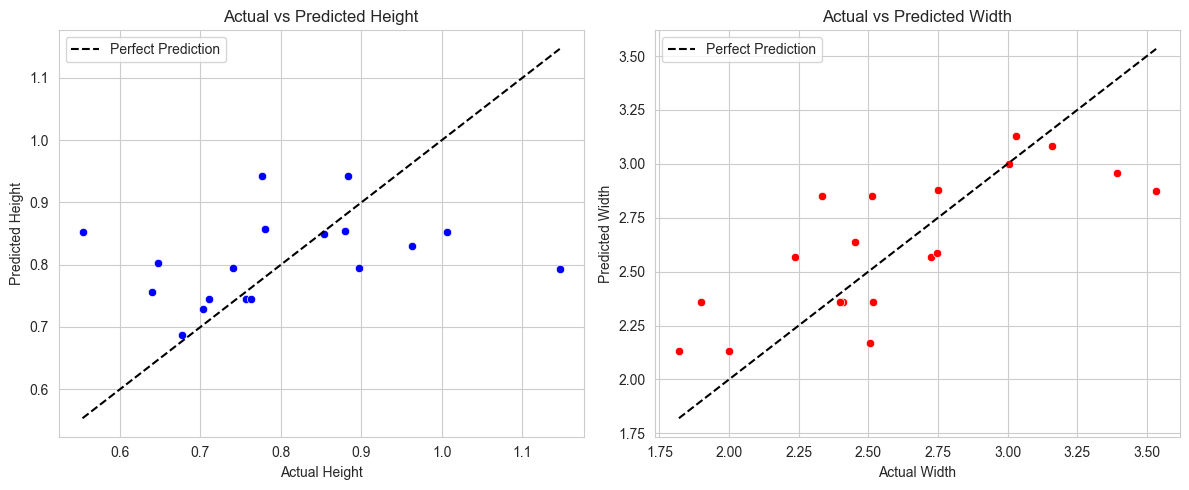

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for height
sns.scatterplot(x=y_val["height_average"], y=y_val["height_predicted"], ax=axes[0], color="blue")
axes[0].plot([y_val["height_average"].min(), y_val["height_average"].max()], 
             [y_val["height_average"].min(), y_val["height_average"].max()], 'k--', label="Perfect Prediction")
axes[0].set_xlabel("Actual Height")
axes[0].set_ylabel("Predicted Height")
axes[0].set_title("Actual vs Predicted Height")
axes[0].legend()

# Scatter plot for width
sns.scatterplot(x=y_val["width_average"], y=y_val["width_predicted"], ax=axes[1], color="red")
axes[1].plot([y_val["width_average"].min(), y_val["width_average"].max()], 
             [y_val["width_average"].min(), y_val["width_average"].max()], 'k--', label="Perfect Prediction")
axes[1].set_xlabel("Actual Width")
axes[1].set_ylabel("Predicted Width")
axes[1].set_title("Actual vs Predicted Width")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

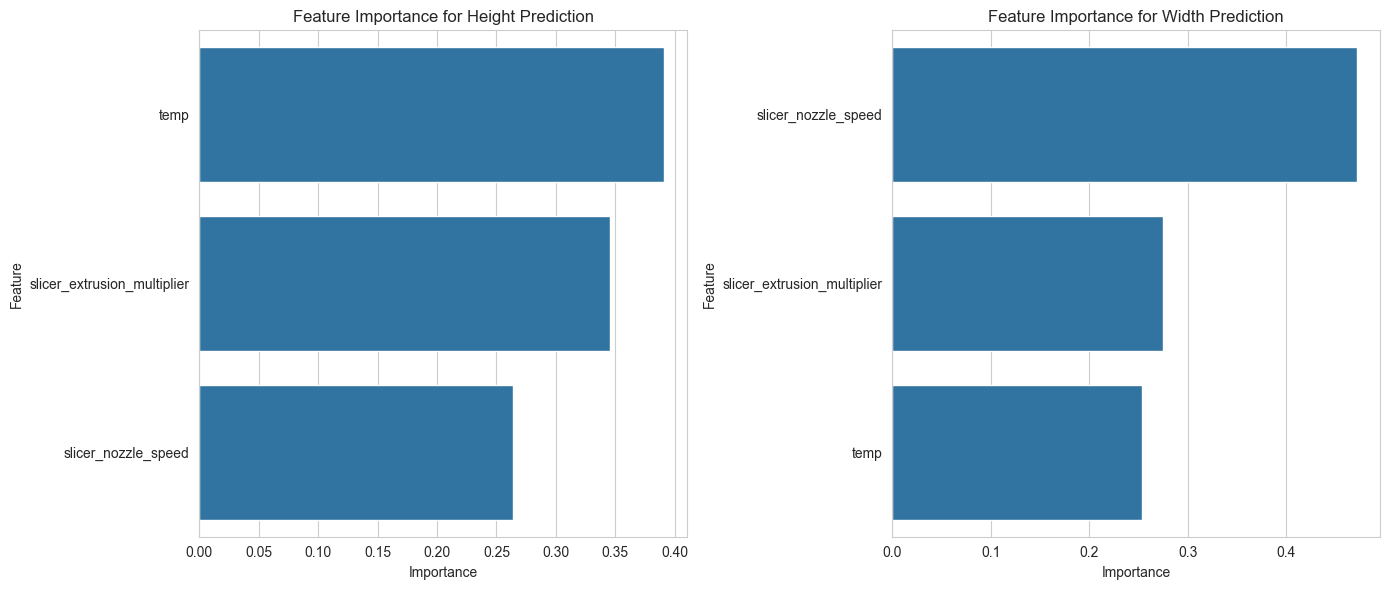

In [42]:
# Feature importance analysis for XGBoost model
import matplotlib.pyplot as plt
import numpy as np

# Retrain the XGBoost model on the full dataset for better feature importance
xgb_height = XGBRegressor(objective='reg:squarederror')
xgb_width = XGBRegressor(objective='reg:squarederror')

# Train the models
xgb_height.fit(X_train, y_train['height_average'])
xgb_width.fit(X_train, y_train['width_average'])

# Get feature importance
height_importance = xgb_height.feature_importances_
width_importance = xgb_width.feature_importances_

# Create feature importance dataframes
feature_names = X_train.columns
height_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': height_importance})
width_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': width_importance})

# Sort by importance
height_imp_df = height_imp_df.sort_values('Importance', ascending=False)
width_imp_df = width_imp_df.sort_values('Importance', ascending=False)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot height feature importance
sns.barplot(x='Importance', y='Feature', data=height_imp_df, ax=axes[0])
axes[0].set_title('Feature Importance for Height Prediction')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Feature')

# Plot width feature importance
sns.barplot(x='Importance', y='Feature', data=width_imp_df, ax=axes[1])
axes[1].set_title('Feature Importance for Width Prediction')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')

plt.tight_layout()
plt.show()

In [43]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create polynomial features (degree=2 includes interaction terms and squared terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Get feature names
poly_feature_names = poly.get_feature_names_out(X.columns)

# Split the data
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(
    X_poly, y, test_size=0.3, random_state=42
)

# Train XGBoost model with polynomial features
xgb_poly_height = XGBRegressor(objective='reg:squarederror')
xgb_poly_width = XGBRegressor(objective='reg:squarederror')

# Train the models
xgb_poly_height.fit(X_poly_train, y_poly_train['height_average'])
xgb_poly_width.fit(X_poly_train, y_poly_train['width_average'])

# Make predictions
height_poly_preds = xgb_poly_height.predict(X_poly_test)
width_poly_preds = xgb_poly_width.predict(X_poly_test)

# Calculate MAE
height_poly_mae = mean_absolute_error(y_poly_test['height_average'], height_poly_preds)
width_poly_mae = mean_absolute_error(y_poly_test['width_average'], width_poly_preds)

print(f"Height MAE with polynomial features: {height_poly_mae:.6f}")
print(f"Width MAE with polynomial features: {width_poly_mae:.6f}")

# Compare with original model
print(f"Improvement in height prediction: {((height_poly_mae - val_height_MAE_loss) / val_height_MAE_loss) * 100:.2f}%")
print(f"Improvement in width prediction: {((width_poly_mae - val_width_MAE_loss) / val_width_MAE_loss) * 100:.2f}%")

Height MAE with polynomial features: 0.098804
Width MAE with polynomial features: 0.262873
Improvement in height prediction: 3.32%
Improvement in width prediction: 9.20%


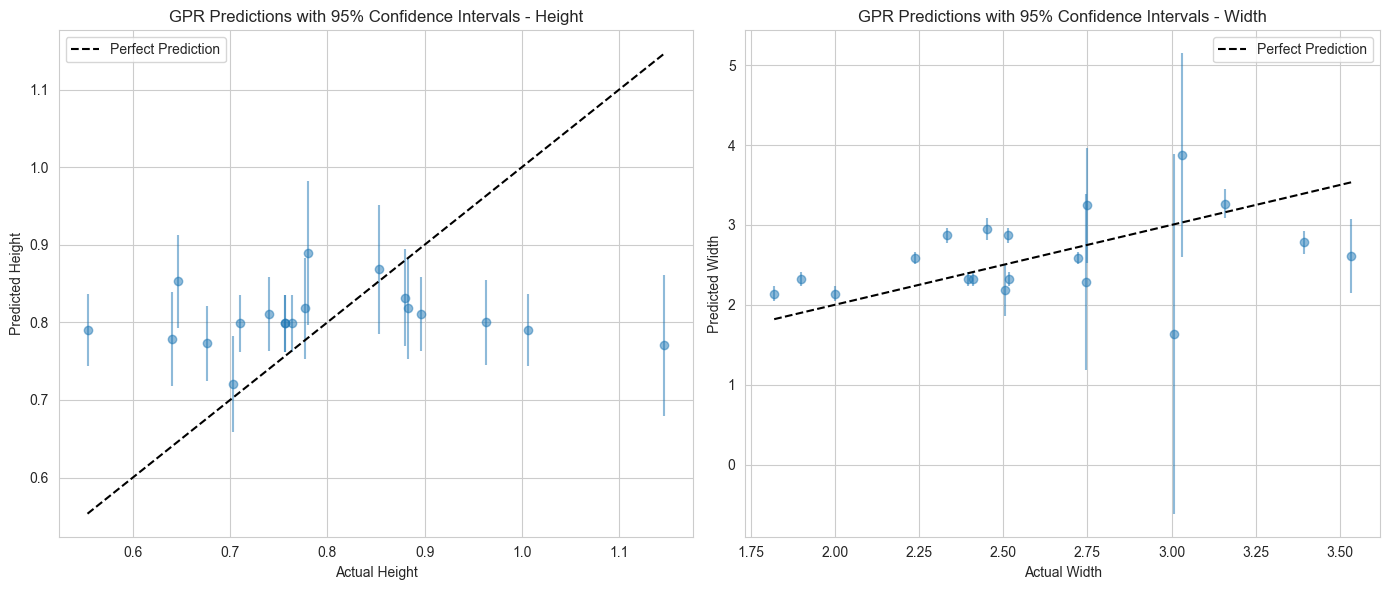

Features associated with high uncertainty in height prediction:
0      slicer_nozzle_speed  slicer_extrusion_multiplier      temp
count             9.000000                     9.000000  9.000000
mean             -0.729007                     0.766446 -0.239164
std               1.342461                     1.161806  1.325431
min              -2.972272                    -1.203290 -2.011657
25%              -1.388791                     0.215172 -1.193583
50%              -1.388791                     0.215172  0.851601
75%               0.590561                     1.230161  0.851601
max               0.590561                     2.390147  0.851601

Features associated with high uncertainty in width prediction:
0      slicer_nozzle_speed  slicer_extrusion_multiplier      temp
count             5.000000                     5.000000  5.000000
mean             -0.913746                     1.491158  0.033528
std               1.517790                     0.919340  1.120194
min           

In [44]:
# Fit GPR with optimized hyperparameters
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Define optimized kernel (replace with your optimized parameters from GridSearchCV)
kernel_height = 1.0 * RBF(length_scale=1.0)
kernel_width = 1.0 * RBF(length_scale=1.0)

# Create GPR models
gpr_height = GaussianProcessRegressor(kernel=kernel_height, alpha=0.01, n_restarts_optimizer=10)
gpr_width = GaussianProcessRegressor(kernel=kernel_width, alpha=0.01, n_restarts_optimizer=10)

# Fit the models
gpr_height.fit(X_train, y_train['height_average'])
gpr_width.fit(X_train, y_train['width_average'])

# Make predictions with standard deviation for validation set
y_height_pred, y_height_std = gpr_height.predict(X_val, return_std=True)
y_width_pred, y_width_std = gpr_width.predict(X_val, return_std=True)

# Plot predictions with uncertainty
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Height plot
axes[0].errorbar(y_val['height_average'], y_height_pred, yerr=1.96*y_height_std, fmt='o', alpha=0.5)
axes[0].plot([y_val['height_average'].min(), y_val['height_average'].max()],
             [y_val['height_average'].min(), y_val['height_average'].max()], 'k--', label="Perfect Prediction")
axes[0].set_xlabel("Actual Height")
axes[0].set_ylabel("Predicted Height")
axes[0].set_title("GPR Predictions with 95% Confidence Intervals - Height")
axes[0].legend()

# Width plot
axes[1].errorbar(y_val['width_average'], y_width_pred, yerr=1.96*y_width_std, fmt='o', alpha=0.5)
axes[1].plot([y_val['width_average'].min(), y_val['width_average'].max()],
             [y_val['width_average'].min(), y_val['width_average'].max()], 'k--', label="Perfect Prediction")
axes[1].set_xlabel("Actual Width")
axes[1].set_ylabel("Predicted Width")
axes[1].set_title("GPR Predictions with 95% Confidence Intervals - Width")
axes[1].legend()

plt.tight_layout()
plt.show()

# Analyze areas of high uncertainty
high_uncertainty_height = y_val[y_height_std > y_height_std.mean()]
high_uncertainty_width = y_val[y_width_std > y_width_std.mean()]

print("Features associated with high uncertainty in height prediction:")
print(X_val.loc[high_uncertainty_height.index].describe())

print("\nFeatures associated with high uncertainty in width prediction:")
print(X_val.loc[high_uncertainty_width.index].describe())

Ensemble model height MAE: 0.095091
Ensemble model width MAE: 0.306568
Improvement over XGBoost for height: -0.57%
Improvement over XGBoost for width: 27.35%


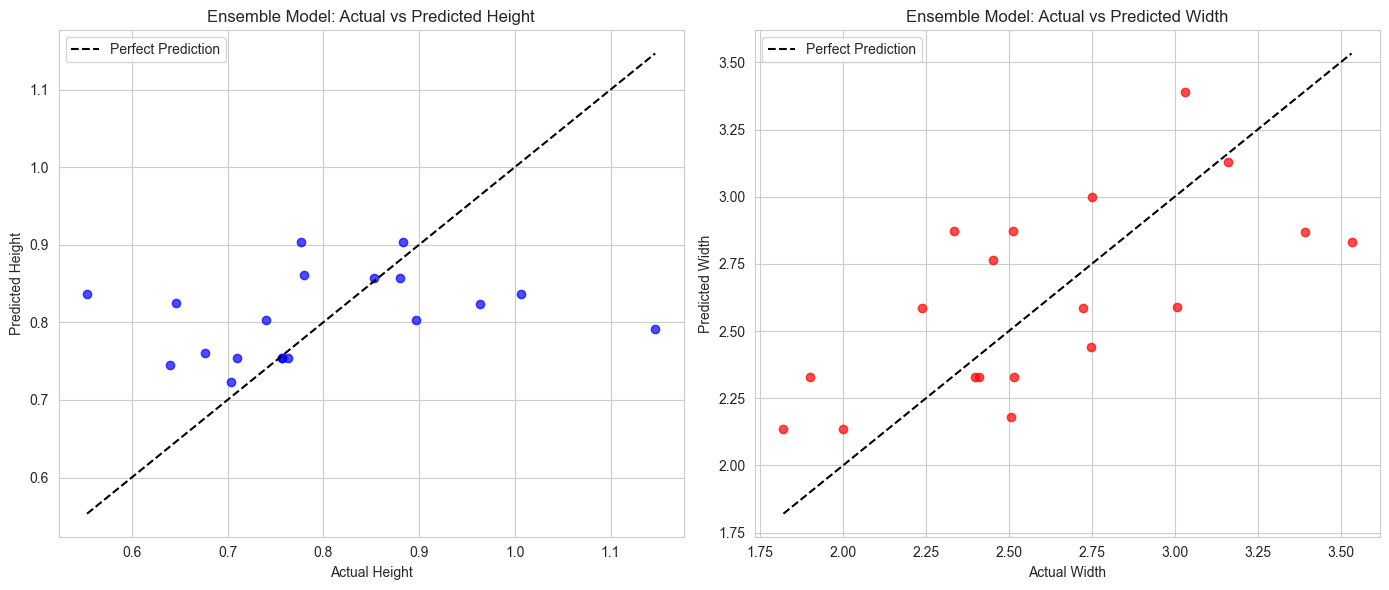

In [45]:
# Create an ensemble model that combines predictions from multiple models
from sklearn.ensemble import VotingRegressor

# Create individual models
xgb_height_final = XGBRegressor(objective='reg:squarederror')
gbr_height_final = GradientBoostingRegressor()
gpr_height_final = GaussianProcessRegressor(kernel=kernel_height, alpha=0.01)

xgb_width_final = XGBRegressor(objective='reg:squarederror')
gbr_width_final = GradientBoostingRegressor()
gpr_width_final = GaussianProcessRegressor(kernel=kernel_width, alpha=0.01)

# Create ensemble models
ensemble_height = VotingRegressor([
    ('xgb', xgb_height_final),
    ('gbr', gbr_height_final),
    ('gpr', gpr_height_final)
])

ensemble_width = VotingRegressor([
    ('xgb', xgb_width_final),
    ('gbr', gbr_width_final),
    ('gpr', gpr_width_final)
])

# Train the ensemble models
ensemble_height.fit(X_train, y_train['height_average'])
ensemble_width.fit(X_train, y_train['width_average'])

# Make predictions
ensemble_height_preds = ensemble_height.predict(X_val)
ensemble_width_preds = ensemble_width.predict(X_val)

# Calculate MAE
ensemble_height_mae = mean_absolute_error(y_val['height_average'], ensemble_height_preds)
ensemble_width_mae = mean_absolute_error(y_val['width_average'], ensemble_width_preds)

print(f"Ensemble model height MAE: {ensemble_height_mae:.6f}")
print(f"Ensemble model width MAE: {ensemble_width_mae:.6f}")
print(f"Improvement over XGBoost for height: {((ensemble_height_mae - val_height_MAE_loss) / val_height_MAE_loss) * 100:.2f}%")
print(f"Improvement over XGBoost for width: {((ensemble_width_mae - val_width_MAE_loss) / val_width_MAE_loss) * 100:.2f}%")

# Plot ensemble predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Height predictions
axes[0].scatter(y_val['height_average'], ensemble_height_preds, color='blue', alpha=0.7)
axes[0].plot([y_val['height_average'].min(), y_val['height_average'].max()],
             [y_val['height_average'].min(), y_val['height_average'].max()], 'k--', label="Perfect Prediction")
axes[0].set_xlabel("Actual Height")
axes[0].set_ylabel("Predicted Height")
axes[0].set_title("Ensemble Model: Actual vs Predicted Height")
axes[0].legend()

# Width predictions
axes[1].scatter(y_val['width_average'], ensemble_width_preds, color='red', alpha=0.7)
axes[1].plot([y_val['width_average'].min(), y_val['width_average'].max()],
             [y_val['width_average'].min(), y_val['width_average'].max()], 'k--', label="Perfect Prediction")
axes[1].set_xlabel("Actual Width")
axes[1].set_ylabel("Predicted Width")
axes[1].set_title("Ensemble Model: Actual vs Predicted Width")
axes[1].legend()

plt.tight_layout()
plt.show()